<a href="https://colab.research.google.com/github/Existanze54/sirius-neural-networks-2024/blob/main/Practices/05S_NN_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Семинар

**Классификация нормы и опухоли на гистологических снимках.**

In [1]:
import os
import warnings

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from tqdm import tqdm


warnings.filterwarnings('ignore')

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
if torch.cuda.is_available():
  print(torch.cuda.get_device_properties(device))

cuda:0
_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40)


Установим пакет для работы с данными набора MedMNIST.

In [3]:
pip install --upgrade git+https://github.com/MedMNIST/MedMNIST.git

  Cloning https://github.com/MedMNIST/MedMNIST.git to /tmp/pip-req-build-kpg1dcuv
  Running command git clone --filter=blob:none --quiet https://github.com/MedMNIST/MedMNIST.git /tmp/pip-req-build-kpg1dcuv
  Resolved https://github.com/MedMNIST/MedMNIST.git to commit db5bff9d0faef4d273896e3cb5542a7000c0239f
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using ca

In [4]:
import medmnist
from medmnist import INFO, Evaluator

Нас интересует датасет PathMNIST с фотографиями гистологических препаратов толстой кишки.

In [5]:
data_flag = 'pathmnist'
download = True

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

Загрузим тренировочные данные.

In [6]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = DataClass(split='train', transform=data_transform, download=download)

100%|██████████| 205615438/205615438 [06:22<00:00, 536885.80it/s]


**Найдите среднее и стандартное отклонение для нормализации данных.**

In [7]:
data_ = torch.Tensor([data[0].numpy() for data in train_dataset])
means = data_.mean(dim=[0,2,3])
stds = data_.std(dim=[0,2,3])

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds)
])

In [8]:
data_.shape

torch.Size([89996, 3, 28, 28])

In [9]:
means, stds

(tensor([0.7405, 0.5330, 0.7058]), tensor([0.1237, 0.1768, 0.1244]))

Нормализуем данные с использованием найденных параметров, обёртываем датасеты в даталоадеры.

In [10]:
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

BATCH_SIZE = 128

train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz


Посмотрим на описание данных и на некоторые примеры.

In [11]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset PathMNIST of size 28 (pathmnist)
    Number of datapoints: 89996
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K

In [12]:
train_dataset.montage(length=1)

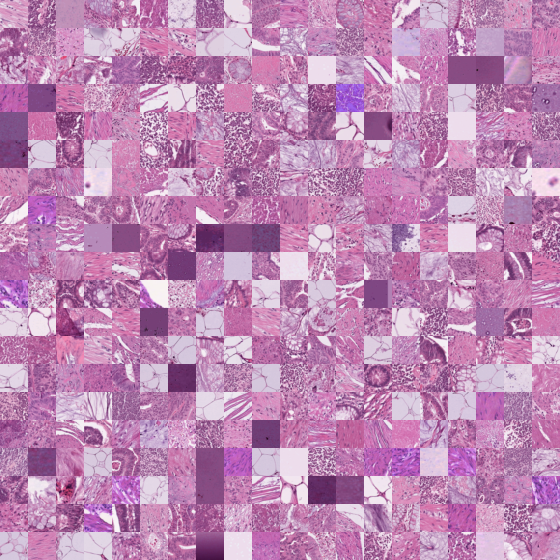

In [13]:
train_dataset.montage(length=20)

**Используя код в следующей ячейке, создайте следующие нейронные сети (для каждой сохраняйте результат):**
 1. С использованием сигмоиды как функции активации;
 2. С использованием ReLU как функции активации;
* a). Без BatchNorm;
* b). С BatchNorm до функции активации;
* c). С BatchNorm после функции активации.
* d)**. С BatchNorm в оптимальном из b) и c) расположений и Dropout (p=0.2) до BatchNorm;
* e)**. С BatchNorm в оптимальном из b) и c) расположений и Dropout (p=0.2) после BatchNorm.
* f) Лучшую из выбранных сетей обучить с OneCycleLR

**Сравните оптимизаторы SGD и AdamW для лучшей нейросети.**

In [14]:
class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.Sigmoid()
            ### Вставьте нужное (активацию, BatchNorm, Dropout и пр.) ###
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.Sigmoid(),
            ### Вставьте нужное (активацию, BatchNorm, Dropout и пр.) ###
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.Sigmoid()
            ### Вставьте нужное (активацию, BatchNorm, Dropout и пр.) ###
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.Sigmoid()
            ### Вставьте нужное (активацию, BatchNorm, Dropout и пр.) ###
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.Sigmoid(),
            ### Вставьте нужное (активацию, BatchNorm, Dropout и пр.) ###
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.Sigmoid(),
            ### Вставьте нужное (активацию, BatchNorm, Dropout и пр.) ###
            nn.Linear(128, 128),
            nn.Sigmoid(),
            ### Вставьте нужное (активацию, BatchNorm, Dropout и пр.) ###
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


device = torch.device("cuda:0")
model = Net(in_channels=n_channels, num_classes=n_classes)
model = model.to(device)

if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()


### Количество эпох и значение коэффициента скорости обучения можно менять!
NUM_EPOCHS = 3
lr = 0.001

optimizer = optim.SGD(model.parameters(), lr=lr)

In [ ]:
#help(nn.BatchNorm2d)

Проведём обучение и посмотрим результаты на тесте.

In [15]:
def train(model):
    print('==> Training ...')
    for epoch in range(NUM_EPOCHS):
      model.train()
      for inputs, targets in tqdm(train_loader):

          inputs = inputs.to(device)
          targets = targets.to(device)

          # forward + backward + optimize
          optimizer.zero_grad()
          outputs = model(inputs)

          if task == 'multi-label, binary-class':
              targets = targets.to(torch.float32)
              loss = criterion(outputs, targets)
          else:
              targets = targets.squeeze()
              loss = criterion(outputs, targets)

          loss.backward()
          optimizer.step()
    print('\n ==> Finished training')

In [16]:
def test_split(model, split):
    model.eval()
    y_score = torch.tensor([]).to(device)

    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze()
                outputs = outputs.softmax(dim=-1)

            y_score = torch.cat((y_score, outputs), 0)

        y_score = y_score.cpu().detach().numpy()

        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)

        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

def test(model):
    print('==> Evaluating ...')
    test_split(model, 'train')
    test_split(model, 'test')

In [17]:
train(model)

==> Training ...


100%|██████████| 704/704 [00:29<00:00, 23.51it/s]


 ==> Finished training


In [18]:
test(model)

==> Evaluating ...
train  auc: 0.495  acc:0.143
test  auc: 0.509  acc:0.172


In [19]:
class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.Sigmoid()
            ### Вставьте нужное (активацию, BatchNorm, Dropout и пр.) ###
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.Sigmoid(),
            ### Вставьте нужное (активацию, BatchNorm, Dropout и пр.) ###
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.Sigmoid()
            ### Вставьте нужное (активацию, BatchNorm, Dropout и пр.) ###
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.Sigmoid()
            ### Вставьте нужное (активацию, BatchNorm, Dropout и пр.) ###
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.Sigmoid(),
            ### Вставьте нужное (активацию, BatchNorm, Dropout и пр.) ###
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.Sigmoid(),
            ### Вставьте нужное (активацию, BatchNorm, Dropout и пр.) ###
            nn.Linear(128, 128),
            nn.Sigmoid(),
            ### Вставьте нужное (активацию, BatchNorm, Dropout и пр.) ###
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


device = torch.device("cuda:0")
model = Net(in_channels=n_channels, num_classes=n_classes)
model = model.to(device)

if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()


### Количество эпох и значение коэффициента скорости обучения можно менять!
NUM_EPOCHS = 3
lr = 0.001

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [20]:
train(model)

==> Training ...


100%|██████████| 704/704 [00:22<00:00, 31.28it/s]


 ==> Finished training


In [21]:
test(model)

==> Evaluating ...
train  auc: 0.424  acc:0.135
test  auc: 0.465  acc:0.082


In [22]:
class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.Sigmoid()
            ### Вставьте нужное (активацию, BatchNorm, Dropout и пр.) ###
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.Sigmoid(),
            ### Вставьте нужное (активацию, BatchNorm, Dropout и пр.) ###
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.Sigmoid()
            ### Вставьте нужное (активацию, BatchNorm, Dropout и пр.) ###
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.Sigmoid()
            ### Вставьте нужное (активацию, BatchNorm, Dropout и пр.) ###
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.Sigmoid(),
            ### Вставьте нужное (активацию, BatchNorm, Dropout и пр.) ###
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.Sigmoid(),
            ### Вставьте нужное (активацию, BatchNorm, Dropout и пр.) ###
            nn.Linear(128, 128),
            nn.Sigmoid(),
            ### Вставьте нужное (активацию, BatchNorm, Dropout и пр.) ###
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


device = torch.device("cuda:0")
model = Net(in_channels=n_channels, num_classes=n_classes)
model = model.to(device)

if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()


### Количество эпох и значение коэффициента скорости обучения можно менять!
NUM_EPOCHS = 3
lr = 0.01

optimizer = optim.AdamW(model.parameters(), lr=lr)

In [23]:
train(model)

==> Training ...


100%|██████████| 704/704 [00:22<00:00, 31.89it/s]


 ==> Finished training


In [24]:
test(model)

==> Evaluating ...
train  auc: 0.500  acc:0.143
test  auc: 0.500  acc:0.172


In [27]:
class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.Sigmoid(),
            nn.BatchNorm2d(16)
            ### Вставьте нужное (активацию, BatchNorm, Dropout и пр.) ###
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.Sigmoid(),
            nn.BatchNorm2d(16),
            ### Вставьте нужное (активацию, BatchNorm, Dropout и пр.) ###
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.Sigmoid(),
            nn.BatchNorm2d(64)
            ### Вставьте нужное (активацию, BatchNorm, Dropout и пр.) ###
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.Sigmoid(),
            nn.BatchNorm2d(64)
            ### Вставьте нужное (активацию, BatchNorm, Dropout и пр.) ###
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.Sigmoid(),
            nn.BatchNorm2d(64),
            ### Вставьте нужное (активацию, BatchNorm, Dropout и пр.) ###
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.Sigmoid(),
            nn.BatchNorm1d(128),
            ### Вставьте нужное (активацию, BatchNorm, Dropout и пр.) ###
            nn.Linear(128, 128),
            nn.Sigmoid(),
            nn.BatchNorm1d(128),
            ### Вставьте нужное (активацию, BatchNorm, Dropout и пр.) ###
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


device = torch.device("cuda:0")
model = Net(in_channels=n_channels, num_classes=n_classes)
model = model.to(device)

if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()


### Количество эпох и значение коэффициента скорости обучения можно менять!
NUM_EPOCHS = 3
lr = 0.01

optimizer = optim.AdamW(model.parameters(), lr=lr)

In [29]:
train(model)

==> Training ...


100%|██████████| 704/704 [00:22<00:00, 31.17it/s]


 ==> Finished training


In [30]:
test(model)

==> Evaluating ...
train  auc: 0.976  acc:0.781
test  auc: 0.950  acc:0.663


In [31]:
class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(16)
            ### Вставьте нужное (активацию, BatchNorm, Dropout и пр.) ###
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            ### Вставьте нужное (активацию, BatchNorm, Dropout и пр.) ###
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(64)
            ### Вставьте нужное (активацию, BatchNorm, Dropout и пр.) ###
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(64)
            ### Вставьте нужное (активацию, BatchNorm, Dropout и пр.) ###
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            ### Вставьте нужное (активацию, BatchNorm, Dropout и пр.) ###
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            ### Вставьте нужное (активацию, BatchNorm, Dropout и пр.) ###
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            ### Вставьте нужное (активацию, BatchNorm, Dropout и пр.) ###
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


device = torch.device("cuda:0")
model = Net(in_channels=n_channels, num_classes=n_classes)
model = model.to(device)

if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()


### Количество эпох и значение коэффициента скорости обучения можно менять!
NUM_EPOCHS = 3
lr = 0.01

optimizer = optim.AdamW(model.parameters(), lr=lr)

In [32]:
train(model)

==> Training ...


100%|██████████| 704/704 [00:23<00:00, 30.14it/s]


 ==> Finished training


In [33]:
test(model)

==> Evaluating ...
train  auc: 0.986  acc:0.801
test  auc: 0.933  acc:0.624


In [ ]:
# 1. Sigmoid, no BatchNorm, SGD usual
# 2. Sigmoid, no BatchNorm, SGD with momentum
# 3. Sigmoid, no BatchNorm, AdamW
# 4. Sigmoid, with BatchNorm, AdamW
# 5. ReLU, with BatchNorm, AdamW

# 6. Dropouts

# 7. ReLU, with BatchNorm, AdamW, OneCycleLR

Пробуем настроить OneCycleLR

In [34]:
start_lr = 1e-8
end_lr = 10
lr_find_epochs = 1
steps = lr_find_epochs * len(train_loader)
smoothing = 0.05

model = Net(in_channels=n_channels, num_classes=n_classes)
model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)

import math

lrs = []
losses = []
optimizer = optim.AdamW(model.parameters(), lr=1e-8)
lr_lambda = lambda x: math.exp(x * math.log(end_lr / start_lr) / (steps))


scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

for epoch in tqdm(range(lr_find_epochs)):
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()
        scheduler.step()

        loss = loss.detach().cpu().numpy()
        if len(losses) > 1:
            loss = smoothing * loss + (1 - smoothing) * losses[-1]
        losses.append(loss)
        lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
        lrs.append(lr_step)

100%|██████████| 1/1 [00:24<00:00, 24.96s/it]


Text(0, 0.5, 'Loss')

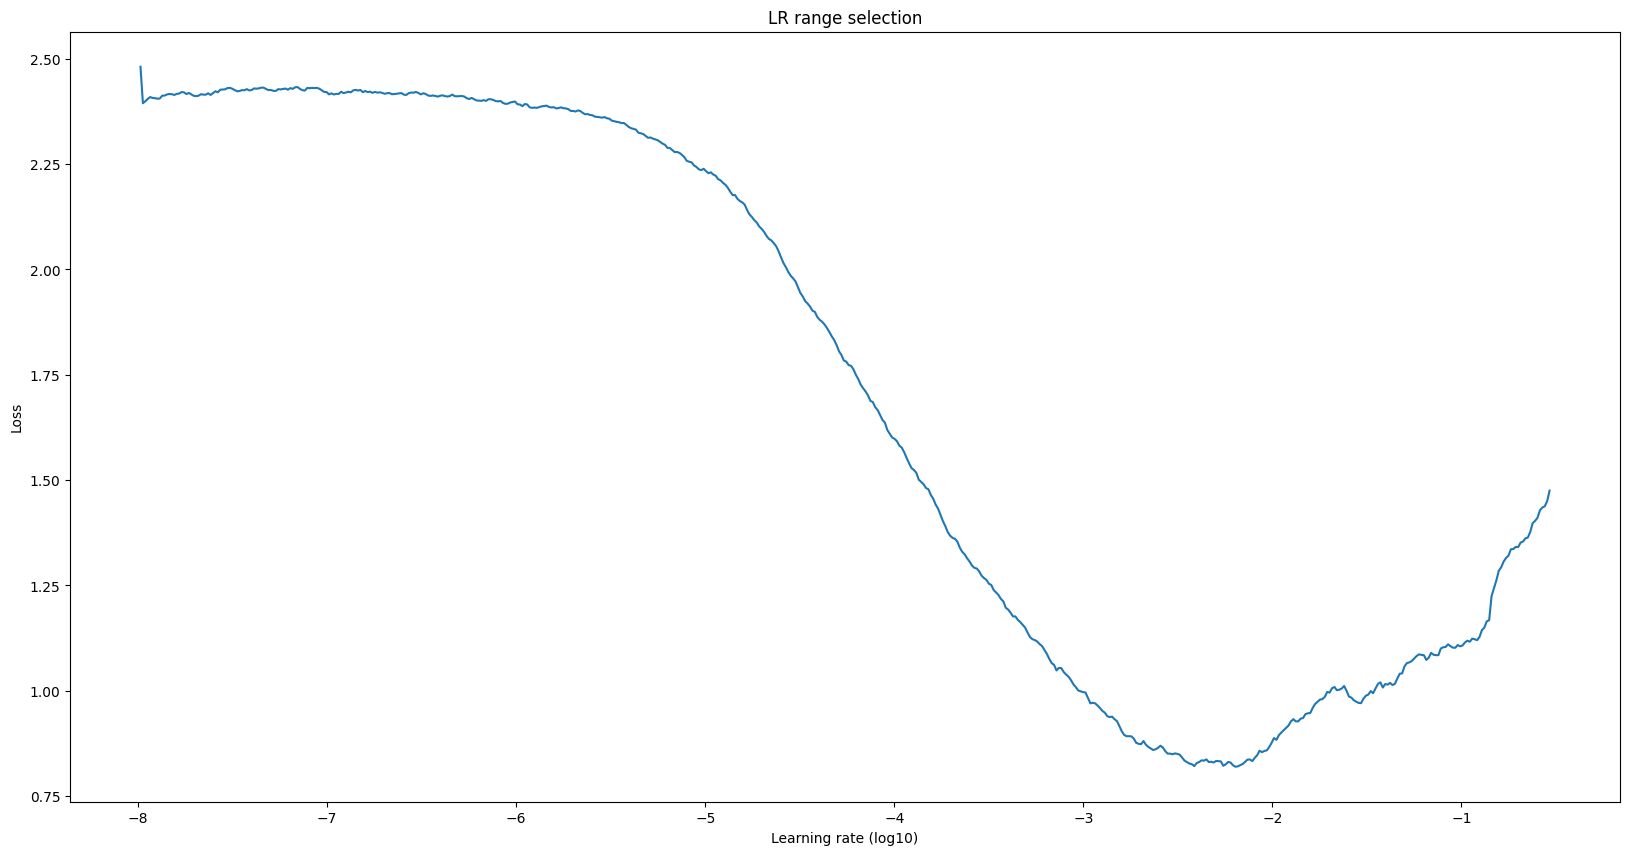

In [39]:
plt.figure(figsize=(20, 10))
plt.title("LR range selection")
plt.plot(np.log10(lrs[:-120]), losses[:-120])
plt.xlabel("Learning rate (log10)")
plt.ylabel("Loss")

Запускаем OneCycleLR

In [41]:
max_lr = 1e-3
div_factor = 25
min_lr = max_lr / div_factor
device = torch.device("cuda:0")
model = Net(in_channels=n_channels, num_classes=n_classes)
model = model.to(device)

if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()


### Количество эпох и значение коэффициента скорости обучения можно менять!
NUM_EPOCHS = 3

optimizer = optim.AdamW(model.parameters(), lr=min_lr)

batch_per_epoch = len(train_loader)

scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                        max_lr=max_lr,
                       steps_per_epoch=batch_per_epoch,
                       epochs=NUM_EPOCHS,
                       pct_start=0.3,#default
                       three_phase=False,
                       div_factor=div_factor)

In [42]:
for epoch in range(NUM_EPOCHS):

    model.train()
    for inputs, targets in tqdm(train_loader):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()
        scheduler.step()

100%|██████████| 704/704 [00:24<00:00, 28.92it/s]


In [44]:
test(model)

==> Evaluating ...
train  auc: 0.997  acc:0.946
test  auc: 0.950  acc:0.779
